### 1.1 Import Necessary Libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
#from torchviz import make_dot

### 1.2 Set Device to cuda

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

### 1.3 Download Fashion MNIST Dataset

In [22]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0), (1))]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor(),transforms.Normalize((0), (1))]))

### 1.4 Visualize a sample Image

torch.Size([1, 28, 28]) 0


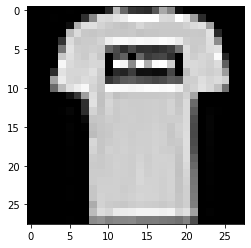

In [23]:
img_tensor, label = train_set[1]
print(img_tensor.shape, label)
plt.imshow(img_tensor.squeeze(), cmap='gray');

### 1.4 Load Data into Batches

In [24]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size)

### 1.5 Assign Output Labels to Numbers for Classification

In [25]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

### 1.6 Construction of CNN

In [26]:
class ClothClassifier(nn.Module):
    
    def __init__(self):
        super(ClothClassifier, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=96, kernel_size=3, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.MaxPool2d(2)
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

### 1.7 Calling The Model CNN

In [27]:
model = ClothClassifier()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

ClothClassifier(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_fea

### 1.8 Testing the data on the Model

In [28]:
num_epochs = 10
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images)
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
        #if count > 1000:
            #break
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images)
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))
        #if count == 1000:
            #break

Iteration: 500, Loss: 0.3344813883304596, Accuracy: 86.47999572753906%
Iteration: 1000, Loss: 0.2050270140171051, Accuracy: 89.8499984741211%
Iteration: 1500, Loss: 0.23506468534469604, Accuracy: 88.47999572753906%
Iteration: 2000, Loss: 0.1707177609205246, Accuracy: 89.0%
Iteration: 2500, Loss: 0.12454786896705627, Accuracy: 91.22999572753906%
Iteration: 3000, Loss: 0.1626216322183609, Accuracy: 91.69999694824219%
Iteration: 3500, Loss: 0.22693867981433868, Accuracy: 91.6199951171875%
Iteration: 4000, Loss: 0.12580421566963196, Accuracy: 92.0%
Iteration: 4500, Loss: 0.13437405228614807, Accuracy: 91.65999603271484%
Iteration: 5000, Loss: 0.2425416111946106, Accuracy: 91.90999603271484%
Iteration: 5500, Loss: 0.09972981363534927, Accuracy: 91.33999633789062%
Iteration: 6000, Loss: 0.15191034972667694, Accuracy: 92.14999389648438%


### Plot Iterations vs Loss

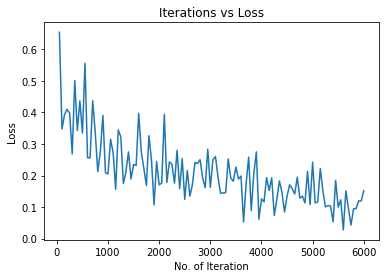

In [29]:
import torch
loss_list_1= torch.tensor(loss_list, device = 'cpu')
iteration_list_1 = torch.tensor(iteration_list, device = 'cpu')
plt.plot(iteration_list_1, loss_list_1)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

### Plot Iterations vs Accuracy

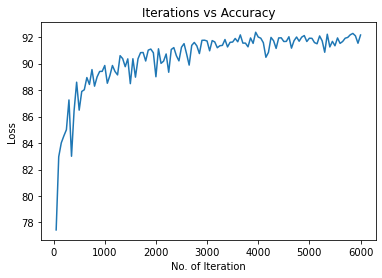

In [34]:
import torch
accuracy_list_1= torch.tensor(accuracy_list, device = 'cpu')
#iteration_list_1 = torch.tensor(iteration_list, device = 'cpu')
plt.plot(iteration_list_1, accuracy_list_1)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Accuracy")
plt.show()

In [31]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 87.70%
Accuracy of Trouser: 99.30%
Accuracy of Pullover: 88.00%
Accuracy of Dress: 87.90%
Accuracy of Coat: 91.00%
Accuracy of Sandal: 98.20%
Accuracy of Shirt: 75.30%
Accuracy of Sneaker: 96.90%
Accuracy of Bag: 97.90%
Accuracy of Ankle Boot: 97.00%


In [32]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [33]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.85      0.85      0.85    120000
           1       0.99      0.98      0.98    120000
           2       0.84      0.88      0.86    120000
           3       0.90      0.91      0.90    120000
           4       0.85      0.85      0.85    120000
           5       0.98      0.97      0.98    120000
           6       0.75      0.71      0.73    120000
           7       0.95      0.96      0.95    120000
           8       0.98      0.98      0.98    120000
           9       0.96      0.96      0.96    120000

    accuracy                           0.90   1200000
   macro avg       0.90      0.90      0.90   1200000
weighted avg       0.90      0.90      0.90   1200000


